In [1]:
import os
import random
import math
import h5py
import concurrent.futures
import matplotlib.pyplot as plt
font = {'size'   : 5}
plt.rc('font', **font)

import numpy as np
import pandas as pd
import pandas.api.types
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
from io import BytesIO

import torch
from torch import nn
import torch.nn.functional as F
import lightning as L

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold, StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


import timm
import wandb

import plotly.express as px
import plotly.graph_objects as go

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
c:\Users\hoang\.conda\envs\bird\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lhkaay (lhklevi). Use `wandb login --relogin` to force relogin


True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


In [4]:
default_config= {
 'VERSION': 'v1.1',
 'DESCRIPTION': 'Use top1 aug from 2020',
 'DATA_PATH': 'isic-2024-challenge',
 
 #-------Global-------#
 'IMAGE_SIZE': 300,
 'SEED': 24,
 #################################################
 
 #-------Image Augmentation-------#

 #################################################

 #-------Training hyperparameter-------#
 'BACKBONE': "tf_efficientnet_b3.in1k", # [ "eca_nfnet_l0" 256,"tf_efficientnet_b0.in1k" 256; "tf_efficientnetv2_s.in21k" 300;  "seresnext26t_32x4d.bt_in1k" 224; "tf_efficientnet_b3.ns_jft_in1k" 300; "resnet34.a1_in1k" 224; "efficientnet_b3.ra2_in1k" 288; "resnet50.a1_in1k" 224; "eca_nfnet_l0.ra2_in1k" 224]
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 64,
 'LOSS': 'BCE'
 #################################################
}

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(default_config['SEED'])

In [6]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

# 1. Dataset

In [11]:
df_data = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
# df_data = df_data.drop(df_data[df_data['target'] == 0].sample(frac=.995).index).reset_index(drop=True)


df_positive = df_data[df_data["target"] == 1].reset_index(drop=True)
df_negative = df_data[df_data["target"] == 0].reset_index(drop=True)

df_data = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]]).reset_index(drop=True)  # positive:negative = 1:20

hdf5_file = h5py.File(f"{default_config['DATA_PATH']}/train-image.hdf5", mode="r")

df_data

C:\Users\hoang\AppData\Local\Temp\ipykernel_17856\2186823440.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274


In [8]:
train_transform = albu.Compose([
        albu.Transpose(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.75),
        albu.OneOf([
            albu.MotionBlur(blur_limit=5),
            albu.MedianBlur(blur_limit=5),
            albu.GaussianBlur(blur_limit=5),
            albu.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),
        albu.OneOf([
            albu.OpticalDistortion(distort_limit=1.0),
            albu.GridDistortion(num_steps=5, distort_limit=1.),
            albu.ElasticTransform(alpha=3),
        ], p=0.7),
        albu.CLAHE(clip_limit=4.0, p=0.7),
        albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),

        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),

        albu.CoarseDropout(max_height=int(default_config['IMAGE_SIZE'] * 0.0375), max_width=int(default_config['IMAGE_SIZE'] * 0.0375), p=0.7),
        
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

valid_transform = albu.Compose([
        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [9]:
class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, df_data, transform):
        self.df_data = df_data

        self.df_positive = df_data[df_data["target"] == 1].reset_index()
        self.df_negative = df_data[df_data["target"] == 0].reset_index()

        self.transform = transform
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        if random.random() >=0.5:
            df = self.df_positive
        else:
            df = self.df_negative
        
        index = index % df.shape[0]
        sample_row = df.iloc[index]
        
        image = np.array(Image.open(BytesIO(self.fp_hdf[sample_row['isic_id']][()])))
        image = self.transform(image=image)['image']
        y = sample_row['target']
        
        return image, y

In [10]:
dataset = ISICDataset(hdf5_file=hdf5_file, df_data=df_data, transform=train_transform)
dataset[0][1]

1

## 1.1 Display one batch in Dataset

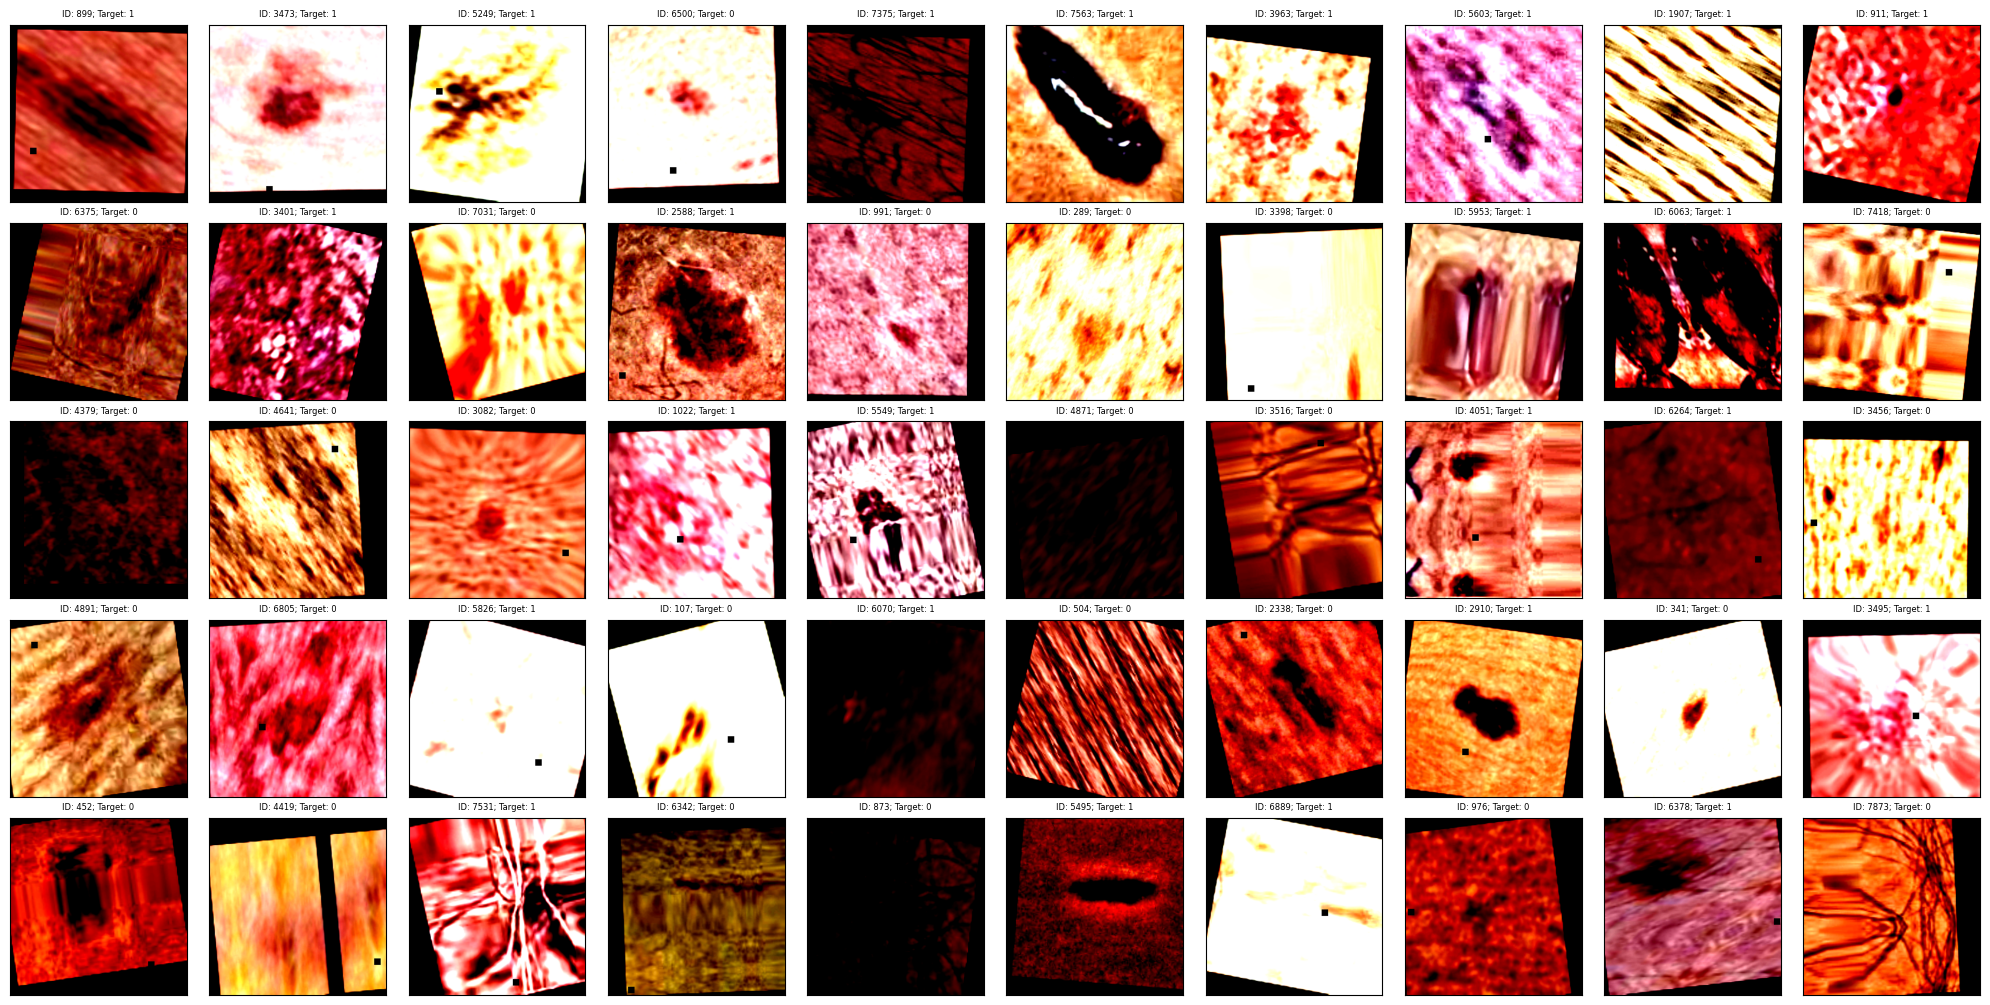

In [11]:
def display_batch(malignant_only=False):
    tmp_df = df_data
    if malignant_only:
        tmp_df = df_data[df_data['target']==1]
    dataset = ISICDataset(hdf5_file=hdf5_file, df_data=tmp_df, transform=train_transform)
    fig = plt.figure(figsize=(20,10))
    
    img_index = np.random.randint(0, len(dataset)-1, 5*10)
    
    for i in range(len(img_index)):
        img, labels = dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy() 
        
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(np.transpose(img, (1,2,0)))
        lbl = labels.item()
        ax.set_title(f'ID: {img_index[i]}; Target: {lbl}')

    plt.tight_layout()
    plt.show()


display_batch(malignant_only=False)

## 2. Model

In [6]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class ISICModel(nn.Module):
    def __init__(self, num_classes):
        super(ISICModel, self).__init__()

        self.backbone = timm.create_model(default_config['BACKBONE'], pretrained=True, num_classes=num_classes)

        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()

        self.globalpooling = GeM()
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ximage):
        x = self.backbone(ximage)
        x = self.globalpooling(x).flatten(1)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [13]:
# model = ISICModel(num_classes=1).to(device)
# inputs = torch.randn(64, 3, 300, 300).to(device)

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     outputs = model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [35]:
ssk = StratifiedGroupKFold(n_splits=default_config["FOLD"])
df_data['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(ssk.split(df_data, df_data.target, df_data.patient_id)):
    df_data.loc[val_idx, 'fold'] = fold

In [36]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

# 3.Training loop

In [37]:
import gc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [38]:
for f in range(default_config["FOLD"]):
    run = wandb.init(project="ISIC2024", name=f"Model_Fold{f}_{default_config['VERSION']}", entity="lhklevi", config=default_config)
    wandb.alert(title=f"Start Model_Fold {f} !!!", text=f"Start Model_Fold {f} !!!")
    # main loop of f-fold
    print('=================================================================================================')
    print(f"============================== Running training for fold {f} ==============================")
    
    train_df = df_data[df_data['fold'] != f].copy().reset_index(drop=True)
    valid_df = df_data[df_data['fold'] == f].copy().reset_index(drop=True)
    
    train_dataset = ISICDataset(hdf5_file, train_df, transform=train_transform)
    valid_dataset = ISICDataset(hdf5_file, valid_df, transform=valid_transform)

    print(f'Train Samples: {len(train_df)}')
#     display_batch(train_dataset)

    print(f'Valid Samples: {len(valid_df)}')
#     display_batch(valid_dataset)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

    model = ISICModel(num_classes=1).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
    # scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])
    # Training loop
    for epoch in range(default_config["EPOCHS"]):
        model.train()
        for idx,batch in enumerate(train_dataloader):
            inputs, targets = batch

            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs).squeeze()

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            print(f'Step {idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}\r', end='', flush=True)
            wandb.log({"Learning Rate":  optimizer.param_groups[-1]['lr']}) #scheduler.get_last_lr()[0]
        model.eval()
        valid_step = []
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                inputs, targets = batch
                inputs = inputs.to(device, dtype=torch.float)

                outputs = model(inputs).squeeze()
                valid_step.append({"logits": outputs, "targets": targets.to(torch.float)})

            output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
            target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

            val_loss = criterion(output_val, target_val)

            gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=['target'])
            pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=['target'])
            
            gt_df['isic_id'] = [f'id_{i}' for i in range(len(gt_df))]
            pred_df['isic_id'] = [f'id_{i}' for i in range(len(pred_df))]
            val_roc_auc = score(gt_df, pred_df, row_id_column_name='isic_id')
            scheduler.step(val_roc_auc)

        print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {loss.item():.4f}, valid_loss: {val_loss:.4f}, valid_score: {val_roc_auc:.4f} lr: {scheduler.get_last_lr()}")
        wandb.log({"Training Loss": loss.item(),"Valid Loss": val_loss, "Valid Score": val_roc_auc})
        gc.collect()

    torch.save(model.state_dict(), f"model/{default_config['VERSION']}/Model_Fold{f}.pt")
    wandb.save(f"model/{default_config['VERSION']}/Model_Fold{f}.pt")

    wandb.alert(title=f"Done Fold {f} !!!", text=f"Done Fold {f} !!!")
    run.finish()

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 0 ==============================
Train Samples: 6602
Valid Samples: 1651


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.3319, valid_loss: 0.4595, valid_score: 0.1178 lr: [0.0001]
Epoch 2/10, train_loss: 0.7342, valid_loss: 0.3850, valid_score: 0.1339 lr: [0.0001]
Epoch 3/10, train_loss: 0.3121, valid_loss: 0.4209, valid_score: 0.1429 lr: [0.0001]
Epoch 4/10, train_loss: 0.1555, valid_loss: 0.3832, valid_score: 0.1486 lr: [0.0001]
Epoch 5/10, train_loss: 0.4140, valid_loss: 0.4080, valid_score: 0.1429 lr: [0.0001]
Epoch 6/10, train_loss: 0.7567, valid_loss: 0.4587, valid_score: 0.1397 lr: [1e-05]
Epoch 7/10, train_loss: 0.5600, valid_loss: 0.4408, valid_score: 0.1483 lr: [1e-05]
Epoch 8/10, train_loss: 0.6991, valid_loss: 0.3751, valid_score: 0.1500 lr: [1e-05]
Epoch 9/10, train_loss: 0.1663, valid_loss: 0.4470, valid_score: 0.1450 lr: [1e-05]
Epoch 10/10, train_loss: 0.1211, valid_loss: 0.4392, valid_score: 0.1448 lr: [1.0000000000000002e-06]


Learning Rate,████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,▃█▃▁▄█▆▇▁▁
Valid Loss,█▂▅▂▄█▆▁▇▆
Valid Score,▁▄▆█▆▆██▇▇
Learning Rate,1e-05
Training Loss,0.12108
Valid Loss,0.43915
Valid Score,0.14477


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 1 ==============================
Train Samples: 6602
Valid Samples: 1651


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.4041, valid_loss: 0.4914, valid_score: 0.1117 lr: [0.0001]
Epoch 2/10, train_loss: 0.2562, valid_loss: 0.4053, valid_score: 0.1340 lr: [0.0001]
Epoch 3/10, train_loss: 0.3469, valid_loss: 0.3675, valid_score: 0.1467 lr: [0.0001]
Epoch 4/10, train_loss: 0.3786, valid_loss: 0.3736, valid_score: 0.1492 lr: [0.0001]
Epoch 5/10, train_loss: 0.5304, valid_loss: 0.4170, valid_score: 0.1467 lr: [0.0001]
Epoch 6/10, train_loss: 0.4346, valid_loss: 0.4121, valid_score: 0.1503 lr: [0.0001]
Epoch 7/10, train_loss: 0.1526, valid_loss: 0.3809, valid_score: 0.1528 lr: [0.0001]
Epoch 8/10, train_loss: 0.1870, valid_loss: 0.4414, valid_score: 0.1463 lr: [0.0001]
Epoch 9/10, train_loss: 0.0780, valid_loss: 0.3935, valid_score: 0.1564 lr: [0.0001]
Epoch 10/10, train_loss: 0.1147, valid_loss: 0.4418, valid_score: 0.1496 lr: [0.0001]


Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,▆▄▅▆█▇▂▃▁▂
Valid Loss,█▃▁▁▄▄▂▅▂▅
Valid Score,▁▄▆▇▆▇▇▆█▇
Learning Rate,0.0001
Training Loss,0.11467
Valid Loss,0.44181
Valid Score,0.14961


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 2 ==============================
Train Samples: 6603
Valid Samples: 1650


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.3742, valid_loss: 0.4316, valid_score: 0.1371 lr: [0.0001]
Epoch 2/10, train_loss: 0.5739, valid_loss: 0.3821, valid_score: 0.1512 lr: [0.0001]
Epoch 3/10, train_loss: 0.4181, valid_loss: 0.3722, valid_score: 0.1532 lr: [0.0001]
Epoch 4/10, train_loss: 0.3307, valid_loss: 0.3643, valid_score: 0.1538 lr: [0.0001]
Epoch 5/10, train_loss: 0.2167, valid_loss: 0.3335, valid_score: 0.1564 lr: [0.0001]
Epoch 6/10, train_loss: 0.3118, valid_loss: 0.3436, valid_score: 0.1593 lr: [0.0001]
Epoch 7/10, train_loss: 0.3832, valid_loss: 0.3366, valid_score: 0.1589 lr: [0.0001]
Epoch 8/10, train_loss: 0.1908, valid_loss: 0.3797, valid_score: 0.1576 lr: [1e-05]
Epoch 9/10, train_loss: 0.4617, valid_loss: 0.3471, valid_score: 0.1615 lr: [1e-05]
Epoch 10/10, train_loss: 0.2148, valid_loss: 0.3662, valid_score: 0.1577 lr: [1e-05]


Learning Rate,████████████████████████████████▁▁▁▁▁▁▁▁
Training Loss,▄█▅▄▁▃▅▁▆▁
Valid Loss,█▄▄▃▁▂▁▄▂▃
Valid Score,▁▅▆▆▇▇▇▇█▇
Learning Rate,1e-05
Training Loss,0.2148
Valid Loss,0.36618
Valid Score,0.15775


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 3 ==============================
Train Samples: 6601
Valid Samples: 1652


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.2825, valid_loss: 0.4036, valid_score: 0.1483 lr: [0.0001]
Epoch 2/10, train_loss: 0.2385, valid_loss: 0.3551, valid_score: 0.1640 lr: [0.0001]
Epoch 3/10, train_loss: 0.1924, valid_loss: 0.3397, valid_score: 0.1615 lr: [0.0001]
Epoch 4/10, train_loss: 0.6582, valid_loss: 0.2988, valid_score: 0.1665 lr: [0.0001]
Epoch 5/10, train_loss: 0.4004, valid_loss: 0.3381, valid_score: 0.1617 lr: [0.0001]
Epoch 6/10, train_loss: 0.9076, valid_loss: 0.3592, valid_score: 0.1621 lr: [1e-05]
Epoch 7/10, train_loss: 0.2854, valid_loss: 0.3264, valid_score: 0.1624 lr: [1e-05]
Epoch 8/10, train_loss: 0.5109, valid_loss: 0.3404, valid_score: 0.1625 lr: [1.0000000000000002e-06]
Epoch 9/10, train_loss: 0.9105, valid_loss: 0.3414, valid_score: 0.1599 lr: [1.0000000000000002e-06]
Epoch 10/10, train_loss: 0.5322, valid_loss: 0.3387, valid_score: 0.1630 lr: [1.0000000000000002e-07]


Learning Rate,████████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training Loss,▂▁▁▆▃█▂▄█▄
Valid Loss,█▅▄▁▄▅▃▄▄▄
Valid Score,▁▇▆█▆▆▆▆▅▇
Learning Rate,0.0
Training Loss,0.53223
Valid Loss,0.33869
Valid Score,0.16305


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)


============================== Running training for fold 4 ==============================
Train Samples: 6604
Valid Samples: 1649


INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.4806, valid_loss: 0.3691, valid_score: 0.1342 lr: [0.0001]
Epoch 2/10, train_loss: 0.3481, valid_loss: 0.3447, valid_score: 0.1391 lr: [0.0001]
Epoch 3/10, train_loss: 0.3621, valid_loss: 0.3459, valid_score: 0.1471 lr: [0.0001]
Epoch 4/10, train_loss: 0.3699, valid_loss: 0.3348, valid_score: 0.1494 lr: [0.0001]
Epoch 5/10, train_loss: 0.3429, valid_loss: 0.3315, valid_score: 0.1535 lr: [0.0001]
Epoch 6/10, train_loss: 0.3938, valid_loss: 0.3248, valid_score: 0.1570 lr: [0.0001]
Epoch 7/10, train_loss: 0.2594, valid_loss: 0.3132, valid_score: 0.1571 lr: [0.0001]
Epoch 8/10, train_loss: 0.1972, valid_loss: 0.3136, valid_score: 0.1613 lr: [0.0001]
Epoch 9/10, train_loss: 0.2551, valid_loss: 0.3526, valid_score: 0.1498 lr: [0.0001]
Epoch 10/10, train_loss: 0.7054, valid_loss: 0.3078, valid_score: 0.1602 lr: [1e-05]


Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,▅▃▃▃▃▄▂▁▂█
Valid Loss,█▅▅▄▄▃▂▂▆▁
Valid Score,▁▂▄▅▆▇▇█▅█
Learning Rate,0.0001
Training Loss,0.70544
Valid Loss,0.30778
Valid Score,0.16017


# Evaluation

In [7]:
df_data_full = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")

C:\Users\hoang\AppData\Local\Temp\ipykernel_17856\782596296.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data_full = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")


In [8]:
model = ISICModel(1)

model.load_state_dict(torch.load(f"model/{default_config['VERSION']}/Model_Fold2.pt"))
model.to(device)
model.eval()


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnet_b3.in1k)
INFO:timm.models._hub:[timm/tf_efficientnet_b3.in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


ISICModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), strid

In [9]:
class ISICTestDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, df_data, transform):
        self.df_data = df_data

        self.transform = transform
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        
        sample_row = self.df_data.iloc[index]
        
        image = np.array(Image.open(BytesIO(self.fp_hdf[sample_row['isic_id']][()])))
        image = self.transform(image=image)['image']
        
        return image
    
valid_transform = albu.Compose([
        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

In [12]:
test_dataset = ISICTestDataset(hdf5_file, df_data_full, valid_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=default_config['BACTHSIZE'], num_workers=2, shuffle=False, pin_memory=True)

In [21]:
all_preds = []
with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to("cuda")
        preds = model(imgs).detach().cpu().numpy()
        preds = np.mean(preds, 0)
        all_preds.extend(preds)
all_preds=np.array(all_preds).flatten()

In [ ]:
y_pred = np.array(all_preds)
y_true = df_data_full['target'].tolist()

score = score(df_data_full[["target"]], pd.DataFrame(y_pred, columns=["prediction"]), "")
print(f"Competition Score: {score}")

# Convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)

# Get unique labels
labels = sorted(np.unique(y_true))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=labels,
    y=labels,
    colorscale='burg',
    zmin=0,

    # Use the maximum value in the confusion matrix
    zmax=np.max(cm),  
    text=cm,
    texttemplate='%{text:.0f}',
    hovertemplate='True: %{y}<br>Predicted: %{x}<br>Count: %{z:,.0f}<extra></extra>',

    # Create a custom hover text format
    customdata = [str(int(val)) for val in cm.flatten()]
))

# Update layout for a transparent background and square aspect ratio
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    xaxis_title='Predicted Labels',
    yaxis_title='True Labels',
    xaxis=dict(constrain='domain'),
    yaxis=dict(constrain='domain', scaleanchor='x'),
    width=700,  
    height=700,  
    margin=dict(t=70, b=70, l=70, r=70) 
)

fig.write_html(f"reports/{default_config['VERSION']}.html")
# Show the plot
fig.show()